# MSCI 434 Term Project

## 1. Import Packages and Licenses

In [4]:
# %pip install gurobipy
import gurobipy as gp
from gurobipy import GRB as GRB

In [67]:
e = gp.Env(empty = True)
e.setParam('HOSTNAME', 'v1040-wn-rt-b-69-164.campus-dynamic.uwaterloo.ca')
e.setParam('HOSTID', 'dc5a3818')
e.setParam('USERNAME', 'sarankan')
e.setParam('KEY', 'GBQGVJSF')
e.setParam('LICENSEID', 2397655)
e.start()

model = gp.Model(env = e)

No parameters matching 'HOSTNAME' found
No parameters matching 'HOSTID' found
No parameters matching 'KEY' found
Set parameter Username
Set parameter LicenseID to value 2397655
Restricted license - for non-production use only - expires 2024-10-28


# 2. Gurobi Setup
Setting up the graph of the instance using networkx in Gurboi 

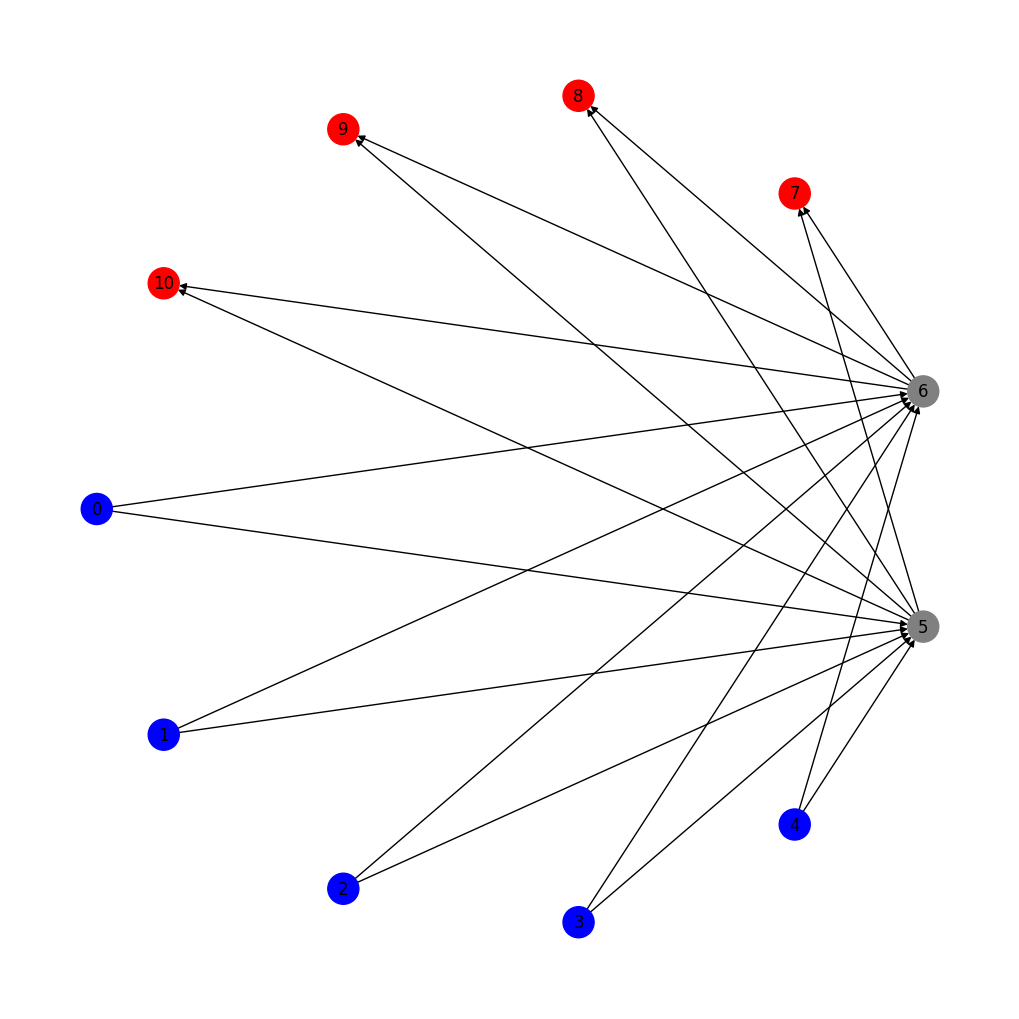

In [68]:
from itertools import combinations, groupby
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

#Suppliers send product to the distribution centres
supplier = 5
#The distribution centres receive the HelloFresh product and package the product
dc = 2
#The customers within receive the packaged goods
customer = 4

# original version from https://stackoverflow.com/a/61961881
def create_graph(suppliers, dcs, customers):
    node_colors = []
    G = nx.DiGraph()
    location_edges = []

    supplierNodes = np.arange(suppliers).tolist()
    G.add_nodes_from(supplierNodes)

    dcNodes = np.arange(suppliers, suppliers + dcs).tolist()
    G.add_nodes_from(dcNodes)

    for i in supplierNodes:
      for j in dcNodes:
        location_edges.append((i,j))

    customerNodes = np.arange(suppliers + dcs, suppliers + dcs + customers).tolist()
    G.add_nodes_from(customerNodes)

    for i in dcNodes:
      for j in customerNodes:
        location_edges.append((i,j))

    G.add_edges_from(location_edges)

    return G


node_colors = []
for i in range(supplier):
  node_colors.append('blue')

for i in range(dc):
  node_colors.append('grey')

for i in range(customer):
  node_colors.append('red')

G = create_graph(supplier, dc, customer)
# visualizing the graph
plt.figure(figsize=(10,10))
nx.draw_shell(G, node_color=node_colors,
        with_labels=True,
        node_size=500)

# 3. Arc & Supply/Demand Setup
Set up costs of transportation along arcs, and supply/demand at nodes. Including the extension of the model (packaging).

In [175]:
from random import randint
import numpy as np

# extract nodes and arcs from the constructed graph
nodes = list(G.nodes)
arcs = list(G.edges)

# Packaging - 3 levels
packaging_levels = [0, 1, 2]
packaging_arcs = {}
for level in packaging_levels:
  packaging_arcs[level] = arcs

# Costs
arc_costs_dict = {}
supplier_costs_dict = {}
storage_costs_dict = {}
arc_quality_knockoffs_dict = {}

K = 1
source_nodes = nodes[:supplier]
sink_nodes = nodes[supplier + dc::]

# Arc costs and supply quantities
arc_costs = [540.56, 4196.64, 641.76, 3712.80, 3665.76, 30.24, 2617.44, 1391.04, 5016.48, 1750.56, 
240.24, 113.57, 3037.44, 3497.76, 3897.60, 3561.60, 1008.00, 520.8]
throughputs = np.zeros((len(nodes), K)) 
supplies = np.random.randint(low=1500, high=2000, size=(supplier))

# Supply purchase cost and DC storage costs
supplier_costs = [1.59, 1.94, 3.01, 2.64, 1.01]
storage_costs = np.random.uniform(low=0, high=0.1, size=(supplier + dc, K))
storage_costs[5] = 20500
storage_costs[6] = 21000
for i in range(supplier):
  supplier_costs_dict[i] = supplier_costs[i]
for i in range(supplier, supplier + dc):
  storage_costs_dict[i] = storage_costs[i]

# Quality levels
initial_quality = np.random.randint(low=95, high=97, size=(supplier))
quality_requirements = np.random.randint(low=91, high=92, size=(len(nodes))) # Set for all nodes, but only important for customer nodes
quality_knockoff = np.random.randint(low=1, high=3, size=(len(arcs), K))
quality = [0] * len(nodes)
for i in range(supplier):
  quality[i] = initial_quality[i]


for i in range(len(arcs)):
  arc_costs_dict[arcs[i]] = {}
  arc_quality_knockoffs_dict[arcs[i]] = {}

packaging_to_cost_factor = {0: 0.85, 1: 1, 2: 1.15}
packaging_to_quality_factor = {0: 1.15, 1: 1, 2: 0.85}
# Set transportation cost for each arc and for all 3 packaging types. Same for quality degradation in transport.
for i in range(len(arcs)):
  for p in packaging_levels:
    cost_factor = packaging_to_cost_factor[p]
    quality_factor = packaging_to_quality_factor[p]
    arc_costs_dict[arcs[i]][p] = cost_factor*arc_costs[i]
    arc_quality_knockoffs_dict[arcs[i]][p] = quality_factor*quality_knockoff[i]

units = []
for idx in range(customer - 1):
    # https://stackoverflow.com/questions/53494200/how-to-split-a-number-into-12-random-in-python-and-all-random-number-sum-to-be-e
    units.append(randint(1,sum(supplies)- sum(units)- customer + idx))
units.append(sum(supplies)-sum(units))

throughputs[source_nodes, range(K)] = supplies

demand_units = sum(throughputs)/customer
for i in range(len(units)):
  throughputs[i + supplier + dc] = demand_units# demand_units

# printing some problem information
print("Source nodes:")
for i in range(supplier):
  print(f'Source node {i} has {throughputs[i]} units of supply')

print("Demand nodes:")
for i in range(supplier + dc, supplier + dc + customer):
  print(f'Demand node {i} has {throughputs[i]} units of demand')
print("Arc costs:")
for i in range(len(arcs)):
  for p in packaging_levels:
    print(f'Transportation cost for arc {i} and packaging level {p}: {arc_costs_dict[arcs[i]][p]}')
    # print(f'Quality degradation (# of levels) for arc {i} and packaging level {p}: {arc_quality_knockoffs_dict[arcs[i]][p]}')

Source nodes:
Source node 0 has [1693.] units of supply
Source node 1 has [1536.] units of supply
Source node 2 has [1579.] units of supply
Source node 3 has [1621.] units of supply
Source node 4 has [1539.] units of supply
Demand nodes:
Demand node 7 has [1992.] units of demand
Demand node 8 has [1992.] units of demand
Demand node 9 has [1992.] units of demand
Demand node 10 has [1992.] units of demand
Arc costs:
Transportation cost for arc 0 and packaging level 0: 459.47599999999994
Transportation cost for arc 0 and packaging level 1: 540.56
Transportation cost for arc 0 and packaging level 2: 621.6439999999999
Transportation cost for arc 1 and packaging level 0: 3567.1440000000002
Transportation cost for arc 1 and packaging level 1: 4196.64
Transportation cost for arc 1 and packaging level 2: 4826.136
Transportation cost for arc 2 and packaging level 0: 545.496
Transportation cost for arc 2 and packaging level 1: 641.76
Transportation cost for arc 2 and packaging level 2: 738.023999

# 4. Adding constraints to the Model
Adding constraints to the model and finding the optimal solution to the instance.

In [184]:
model = gp.Model("HelloFresh Meal Kit Delivery Supply Chain Optimization")

meal_kits = model.addVars(packaging_levels, arcs, vtype=GRB.INTEGER, name='meal_kits') # meal kits in packaging P on each arc
facility_quality = model.addVars(nodes, packaging_levels, vtype=GRB.INTEGER, name='facility_quality')

max_capacity = np.random.randint(low=1000, high=1500)

# Experiment
for s in range(supplier):
  for p in packaging_levels:
    model.addConstr(facility_quality[s, p] == initial_quality[s])
print("FACILITY QUALITY: ", facility_quality)

# supply
for j in range(supplier):
  total = 0
  for i in range(supplier, supplier + dc):
    for p in packaging_levels:
      total += meal_kits[p, j, i]
  model.addConstr(total == throughputs[j])


# intermediary nodes
for i in range(supplier, supplier + dc): # DC's
  # Supply
  incoming = 0
  outgoing = 0
  for supply in range(supplier): # Suppliers's
    for p in packaging_levels: # 3 arc levels
      incoming += meal_kits[p, supply, i]
      # Quality decrease from transport
      degraded_quality = initial_quality[supply] - arc_quality_knockoffs_dict[arcs[supply]][p] # degraded_quality = facility_quality[supply, p] - arc_quality_knockoffs_dict[arcs[supply]][p]
      model.addConstr(facility_quality[i, p] >= degraded_quality)

  for d in range(supplier + dc, supplier + dc + customer): # Customers/demand nodes
    for p in packaging_levels:
      outgoing += meal_kits[p, i, d]
  model.addConstr(incoming == outgoing)
  
# demand
for j in range(supplier + dc, supplier + dc + customer): # Customers/demand nodes
  total = 0
  for i in range(supplier, supplier + dc): # DC's
    for p in packaging_levels:
      total += meal_kits[p, i,j] # demand
      degraded_quality = facility_quality[i, p] - arc_quality_knockoffs_dict[arcs[i]][p]
      model.addConstr(facility_quality[j, p] >= degraded_quality)
    model.addConstr(total == throughputs[j]) # was -throughputs[j]
  for p in packaging_levels:
    model.addConstr(facility_quality[j, p] >= quality_requirements[j]) # quality must meet min. required level

# capacity constraints
for (i,j) in arcs:
  for p in packaging_levels:
    model.addConstr(meal_kits[p, i,j] <= max_capacity)
    model.addConstr(meal_kits[p, i,j] >= 0)

# set objective
model.setObjective(
    sum([(meal_kits[p, i,j]*arc_costs_dict[(i,j)][p]) for (i,j) in arcs for p in packaging_levels]) + # transportation cost
    sum([(meal_kits[p, i,j]*supplier_costs_dict[i]) for i in range(supplier) for j in range(supplier, supplier + dc) for p in packaging_levels]) + # supply cost
    sum([(meal_kits[p, i,j]*storage_costs[j]) for i in range(supplier) for j in range(supplier, supplier + dc) for p in packaging_levels]) # storage cost
    , GRB.MINIMIZE # storage cost
)

# optimize
model.optimize()
print(model.display())

# Output everything
for i in range(supplier, supplier + dc):
  print("Quality at DC: ", facility_quality[i, 0])

for i in range(supplier + dc, supplier + dc + customer):
  print("Quality at facility: ", facility_quality[i, 0])
  print("Required quality: ", quality_requirements[i])

for arc in meal_kits:
  print(f'Packaging level {arc[0]} on Arc {arc[1]} to {arc[2]}: {meal_kits[arc]}')


FACILITY QUALITY:  {(0, 0): <gurobi.Var *Awaiting Model Update*>, (0, 1): <gurobi.Var *Awaiting Model Update*>, (0, 2): <gurobi.Var *Awaiting Model Update*>, (1, 0): <gurobi.Var *Awaiting Model Update*>, (1, 1): <gurobi.Var *Awaiting Model Update*>, (1, 2): <gurobi.Var *Awaiting Model Update*>, (2, 0): <gurobi.Var *Awaiting Model Update*>, (2, 1): <gurobi.Var *Awaiting Model Update*>, (2, 2): <gurobi.Var *Awaiting Model Update*>, (3, 0): <gurobi.Var *Awaiting Model Update*>, (3, 1): <gurobi.Var *Awaiting Model Update*>, (3, 2): <gurobi.Var *Awaiting Model Update*>, (4, 0): <gurobi.Var *Awaiting Model Update*>, (4, 1): <gurobi.Var *Awaiting Model Update*>, (4, 2): <gurobi.Var *Awaiting Model Update*>, (5, 0): <gurobi.Var *Awaiting Model Update*>, (5, 1): <gurobi.Var *Awaiting Model Update*>, (5, 2): <gurobi.Var *Awaiting Model Update*>, (6, 0): <gurobi.Var *Awaiting Model Update*>, (6, 1): <gurobi.Var *Awaiting Model Update*>, (6, 2): <gurobi.Var *Awaiting Model Update*>, (7, 0): <gurob

/var/folders/b5/30vg695j1lb1xbk9tgx40n1w0000gn/T/ipykernel_2928/23740719.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  model.addConstr(total == throughputs[j])
/var/folders/b5/30vg695j1lb1xbk9tgx40n1w0000gn/T/ipykernel_2928/23740719.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  model.addConstr(facility_quality[i, p] >= degraded_quality)
/var/folders/b5/30vg695j1lb1xbk9tgx40n1w0000gn/T/ipykernel_2928/23740719.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy